In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

# Boosting Libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Additional utilities
from scipy.stats import randint, uniform, loguniform
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import time
import warnings

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Load the data
df = pd.read_csv(r"C:\Users\Arin\OneDrive\Desktop\Projects\Credit Card Default Prediction\UCI_Credit_Card.csv")

# Clean up column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace(".", "_")

In [8]:
# Process categorical variables 
education_map = {
    0: 0,  # Unknown
    1: 1,  # Graduate School
    2: 2,  # University
    3: 3,  # High School
    4: 4,  # Others
    5: 0,  # Unknown
    6: 0,  # Unknown
}
df["education_cat"] = df["education"].map(education_map).astype("category")

df["marriage_cat"] = df["marriage"].astype("category")# 0: Unknown, 1: Married, 2: Single, 3: Other

df["sex_cat"] = df["sex"].astype("category")  # 1: Male, 2: Female

# Drop original categorical variables
df = df.drop(columns=["education", "marriage", "sex"])

# Convert PAY_# status columns to category (keeping numeric values)
for n in np.arange(0, 7):
    if n != 1:
        df[f"pay_{n}"] = df[f"pay_{n}"].astype("category")

In [10]:
#  Derived Features

# Payment delay trend (linear slope)
pay_cols = [f"pay_{n}" for n in np.arange(0, 7) if n != 1]
df["payment_delay_trend"] = df[pay_cols].apply(
    lambda x: np.polyfit(range(len(x)), x.astype(float), 1)[0], axis=1
)

# Maximum payment delay
df["max_payment_delay"] = df[pay_cols].astype(float).max(axis=1)

# Credit utilization ratios
for n in np.arange(1, 7):
    df[f"utilization_ratio_{n}"] = df[f"bill_amt{n}"] / df["limit_bal"].replace(0, np.nan)

In [11]:
# Check for missing values
print("\nCheck for missing values:")
print(df.isnull().sum().any())

# Check final data shape
print("\nData shape:")
print(df.shape)


Check for missing values:
False

Data shape:
(30000, 33)


In [13]:
# Define feature types
cat_cols = df.select_dtypes(include=["category"]).columns.tolist()
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("\nCheck all columns are captured:")
df.shape[1] == len(cat_cols) + len(num_cols)


Check all columns are captured:


True

# Class distribution and imbalance handling

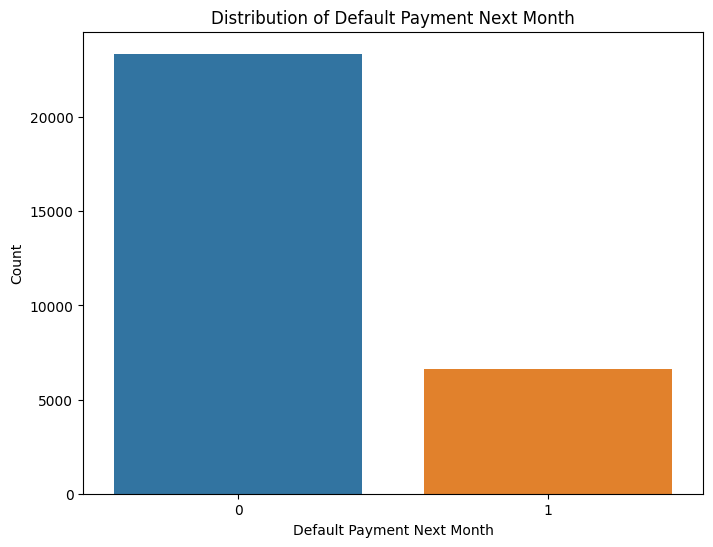


Overall default rate: 22.12%


In [14]:
# Target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="default_payment_next_month", data=df)
plt.title("Distribution of Default Payment Next Month")
plt.xlabel("Default Payment Next Month")
plt.ylabel("Count")
plt.show()

default_rate = df["default_payment_next_month"].value_counts(normalize=True)[1].round(4)
print(f"\nOverall default rate: {default_rate*100}%")

# Data Preparation

In [33]:
# Data preparation
X = df.drop(columns=["default_payment_next_month", "id"])
y = df["default_payment_next_month"]

num_cols = [col for col in num_cols if col not in ['id', 'default_payment_next_month']]

# Split data into train+val and test first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

In [34]:
# Oversampling with SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

In [35]:
# Check resampled data shape and distribution
print("\nResampled data shape:")
print(X_train_resampled.shape)
print(y_train_resampled.value_counts(normalize=True))


Resampled data shape:
(37382, 31)
0    0.5
1    0.5
Name: default_payment_next_month, dtype: float64


# Testing Logistic Regression on the Dataset

In [36]:
# Define a dictionary to store the best models
best_models = {}

# KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [37]:
# Define preprocessor     
log_reg_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Logistic Regression pipeline
log_reg_pipeline = ImbPipeline([
    ("preprocess", log_reg_preprocessor),
    ("clf", LogisticRegression(solver="saga", max_iter=1000, random_state=RANDOM_STATE)),
])

# Hyperparameter space
log_reg_param_grid = {
    "clf__C": loguniform(1e-3, 10),
    "clf__penalty": ["l1", "l2"],
}

# RandomizedSearchCV
log_reg_cv = RandomizedSearchCV(
    estimator=log_reg_pipeline,
    param_distributions=log_reg_param_grid,
    n_iter=15,
    cv=kf,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit model
print("Training Logistic Regression...")
start_time = time.time()

log_reg_cv.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
duration = end_time - start_time

# Store results
best_models["Logistic Regression"] = {
    "best_estimator": log_reg_cv.best_estimator_,
    "training_time_seconds": duration,
    "best_params": log_reg_cv.best_params_,
    "best_f1_score": log_reg_cv.best_score_,
}

print(f"Done. Best f1 score: {log_reg_cv.best_score_:.4f} | Training Time: {duration:.1f}s")

Training Logistic Regression...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Done. Best f1 score: 0.8713 | Training Time: 163.7s


In [46]:
# Logistic Regression Results
y_pred = log_reg_cv.predict(X_test)
y_pred_proba = log_reg_cv.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Results:")
print(f"Best Parameters: {best_models['Logistic Regression']['best_params']}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


Logistic Regression Results:
Best Parameters: {'clf__C': 0.24810409748678097, 'clf__penalty': 'l1'}
Accuracy: 0.8180
Precision: 0.6612
Recall: 0.3632
F1: 0.4689
ROC AUC: 0.7610


# Testing Tree based Models

In [39]:
# Preprocess
tree_preprocessor = ColumnTransformer([
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
], remainder="passthrough")

In [40]:
# Model configurations
model_configs = {
    "Random Forest": {
        "pipeline": ImbPipeline([
            ("preprocessor", tree_preprocessor),
            ("clf", RandomForestClassifier(
                random_state=RANDOM_STATE, 
                class_weight="balanced", 
                n_jobs=-1
            ))
        ]),
        "tuning_params": {
            "clf__n_estimators": randint(100, 200),
            "clf__max_depth": randint(5, 20),
            "clf__min_samples_split": randint(2, 10),
            "clf__min_samples_leaf": randint(1, 5),
        },
    },
    "AdaBoost": {
        "pipeline": ImbPipeline([
            ("preprocessor", tree_preprocessor),
            ("clf", AdaBoostClassifier(
                estimator=DecisionTreeClassifier(
                    max_depth=1,
                    random_state=RANDOM_STATE,
                    class_weight="balanced"
                ),
                random_state=RANDOM_STATE
            ))
        ]),
        "tuning_params": {
            "clf__n_estimators": randint(50, 200),
            "clf__learning_rate": loguniform(1e-2, 0.3),
            "clf__estimator__max_depth": randint(1, 5),
        },
    },
    "XGBoost": {
        "pipeline": ImbPipeline([
            ("preprocessor", tree_preprocessor),
            ("clf", xgb.XGBClassifier(
                random_state=RANDOM_STATE,
                eval_metric="logloss",
                use_label_encoder=False,
                enable_categorical=False,  
                verbosity=0
            ))
        ]),
        "tuning_params": {
            "clf__n_estimators": randint(100, 200),
            "clf__max_depth": randint(3, 8),
            "clf__learning_rate": loguniform(1e-2, 0.3),
            "clf__subsample": uniform(0.7, 0.3),
            "clf__scale_pos_weight": loguniform(1, 10),
        },
    },
    "LightGBM": {
        "pipeline": ImbPipeline([
            ("clf", lgb.LGBMClassifier(
                random_state=RANDOM_STATE,
                eval_metric="binary_logloss",
                categorical_features=cat_cols,
                verbose=-1
            ))
        ]),
        "tuning_params": {
            "clf__n_estimators": randint(100, 200),
            "clf__max_depth": randint(3, 8),
            "clf__learning_rate": loguniform(1e-2, 0.3),
            "clf__num_leaves": randint(20, 50),
        },
    },
    "CatBoost": {
        "pipeline": ImbPipeline([
            ("clf", CatBoostClassifier(
                random_state=RANDOM_STATE,
                eval_metric="Logloss",
                cat_features=cat_cols,
                verbose=0,
            ))
        ]),
        "tuning_params": {
            "clf__iterations": randint(100, 300),
            "clf__depth": randint(3, 8),
            "clf__learning_rate": loguniform(1e-2, 0.3),
        },
    },
}

In [41]:
# Train and tune models
for model_name, config in model_configs.items():
    print(f"\nTraining and tuning {model_name}...")

    start_time = time.time()

    search = RandomizedSearchCV(
        estimator=config["pipeline"],
        param_distributions=config["tuning_params"],
        n_iter=15,
        cv=kf,
        scoring="f1",
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
    )

    search.fit(X_train, y_train)

    end_time = time.time()
    duration = end_time - start_time

    best_models[model_name] = {
        "best_estimator": search.best_estimator_,
        "training_time_seconds": duration,
        "best_params": search.best_params_,
        "best_f1_score": search.best_score_,
    }

    print(f"{model_name} done. Best F1: {search.best_score_:.4f} | Time: {duration:.1f}s")


Training and tuning Random Forest...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Random Forest done. Best F1: 0.5440 | Time: 61.7s

Training and tuning AdaBoost...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
AdaBoost done. Best F1: 0.5351 | Time: 112.9s

Training and tuning XGBoost...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
XGBoost done. Best F1: 0.5398 | Time: 13.5s

Training and tuning LightGBM...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
LightGBM done. Best F1: 0.4791 | Time: 29.8s

Training and tuning CatBoost...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
CatBoost done. Best F1: 0.4757 | Time: 214.7s


# Evaluating & Testing the Models

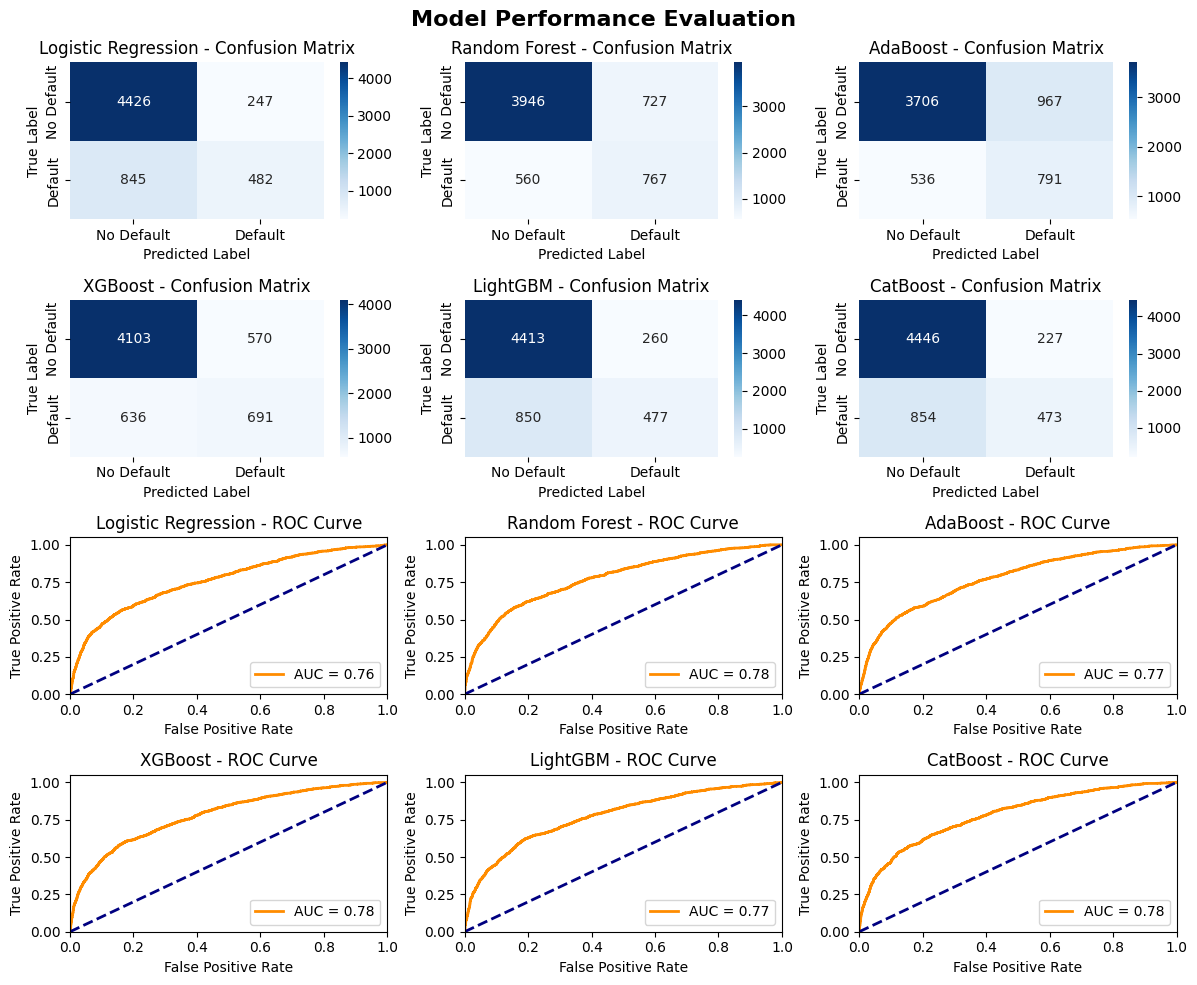


 Model Comparison Summary Table:
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC | Training Time   |
|:--------------------|-----------:|------------:|---------:|-----------:|----------:|:----------------|
| Logistic Regression |     0.818  |      0.6612 |   0.3632 |     0.4689 |    0.761  | 2 min 43 sec    |
| Random Forest       |     0.7855 |      0.5134 |   0.578  |     0.5438 |    0.7767 | 1 min 1 sec     |
| AdaBoost            |     0.7495 |      0.4499 |   0.5961 |     0.5128 |    0.7728 | 1 min 52 sec    |
| XGBoost             |     0.799  |      0.548  |   0.5207 |     0.534  |    0.7801 | 0 min 13 sec    |
| LightGBM            |     0.815  |      0.6472 |   0.3595 |     0.4622 |    0.7739 | 0 min 29 sec    |
| CatBoost            |     0.8198 |      0.6757 |   0.3564 |     0.4667 |    0.7811 | 3 min 34 sec    |


In [42]:
# Results summary
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
fig.suptitle("Model Performance Evaluation", fontsize=16, fontweight='bold')

axes = axes.flatten()

metrics_summary = []

for idx, (model_name, model_info) in enumerate(best_models.items()):
    model = model_info["best_estimator"]
    
    predictions = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, pred_proba)

    total_seconds = model_info["training_time_seconds"]
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    training_time = f"{minutes} min {seconds} sec"

    metrics_summary.append({
        "Model": model_name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "Training Time": training_time
    })

    # confusion matrix
    cm = confusion_matrix(y_test, predictions)

    sns.heatmap(
        cm,
        annot=True, 
        fmt="d",
        cmap="Blues",
        xticklabels=["No Default", "Default"],
        yticklabels=["No Default", "Default"],
        ax=axes[idx]
    )
    axes[idx].set_title(f"{model_name} - Confusion Matrix")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")

    # ROC curve
    roc_idx = idx + len(best_models)
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    axes[roc_idx].plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
    axes[roc_idx].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    axes[roc_idx].set_xlim([0.0, 1.0])
    axes[roc_idx].set_ylim([0.0, 1.05])
    axes[roc_idx].set_xlabel("False Positive Rate")
    axes[roc_idx].set_ylabel("True Positive Rate")
    axes[roc_idx].set_title(f"{model_name} - ROC Curve")
    axes[roc_idx].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Create and display summary DataFrame
df_metrics = pd.DataFrame(metrics_summary)
print("\n Model Comparison Summary Table:")
print(df_metrics.to_markdown(index=False))

Logistic Regression: Feature importance not available.



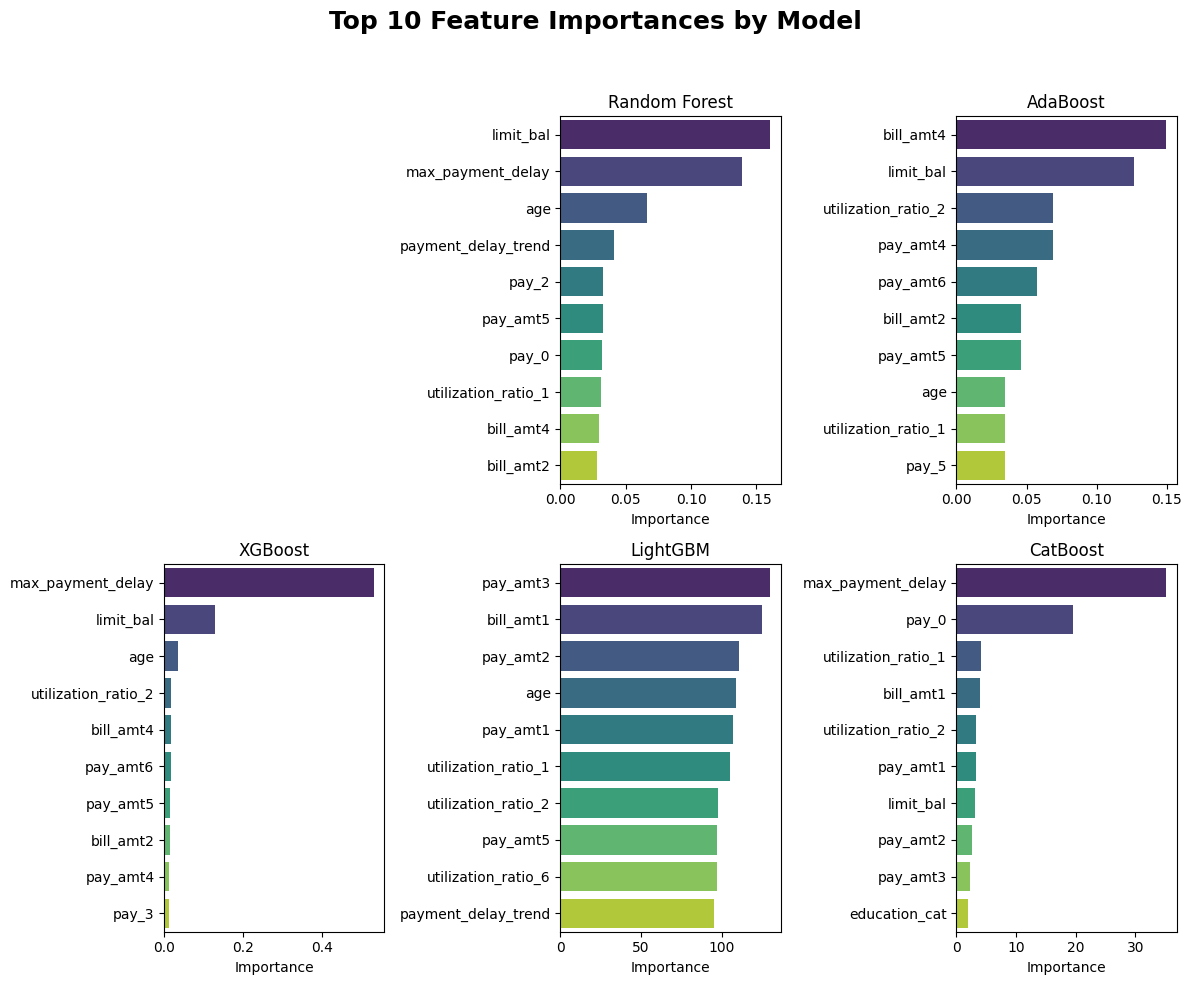

In [43]:
# Simple Feature Importance Plot for Supported Models
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()
fig.suptitle("Top 10 Feature Importances by Model", fontsize=18, fontweight='bold')

for idx, (model_name, model_info) in enumerate(best_models.items()):
    if idx >= len(axes):
        break

    model = model_info["best_estimator"]

    # Get classifier from pipeline
    clf = model.named_steps["clf"] if hasattr(model, "named_steps") else model

    if not hasattr(clf, "feature_importances_"):
        print(f"{model_name}: Feature importance not available.\n")
        fig.delaxes(axes[idx])
        continue

    importances = clf.feature_importances_
    feature_names = X_train.columns if hasattr(X_train, "columns") else [f"Feature {i}" for i in range(len(importances))]

    # Get top 10 features
    indices = np.argsort(importances)[-10:][::-1]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]

    # Plot
    sns.barplot(x=top_importances, y=top_features, ax=axes[idx], palette="viridis")
    axes[idx].set_title(model_name)
    axes[idx].set_xlabel("Importance")
    axes[idx].set_ylabel("")

# Remove extra subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [44]:
df.shape[0]

30000

In [30]:
df[df['default_payment_next_month']==1].count()

id                            6636
limit_bal                     6636
age                           6636
pay_0                         6636
pay_2                         6636
pay_3                         6636
pay_4                         6636
pay_5                         6636
pay_6                         6636
bill_amt1                     6636
bill_amt2                     6636
bill_amt3                     6636
bill_amt4                     6636
bill_amt5                     6636
bill_amt6                     6636
pay_amt1                      6636
pay_amt2                      6636
pay_amt3                      6636
pay_amt4                      6636
pay_amt5                      6636
pay_amt6                      6636
default_payment_next_month    6636
education_cat                 6636
marriage_cat                  6636
sex_cat                       6636
payment_delay_trend           6636
max_payment_delay             6636
utilization_ratio_1           6636
utilization_ratio_2 

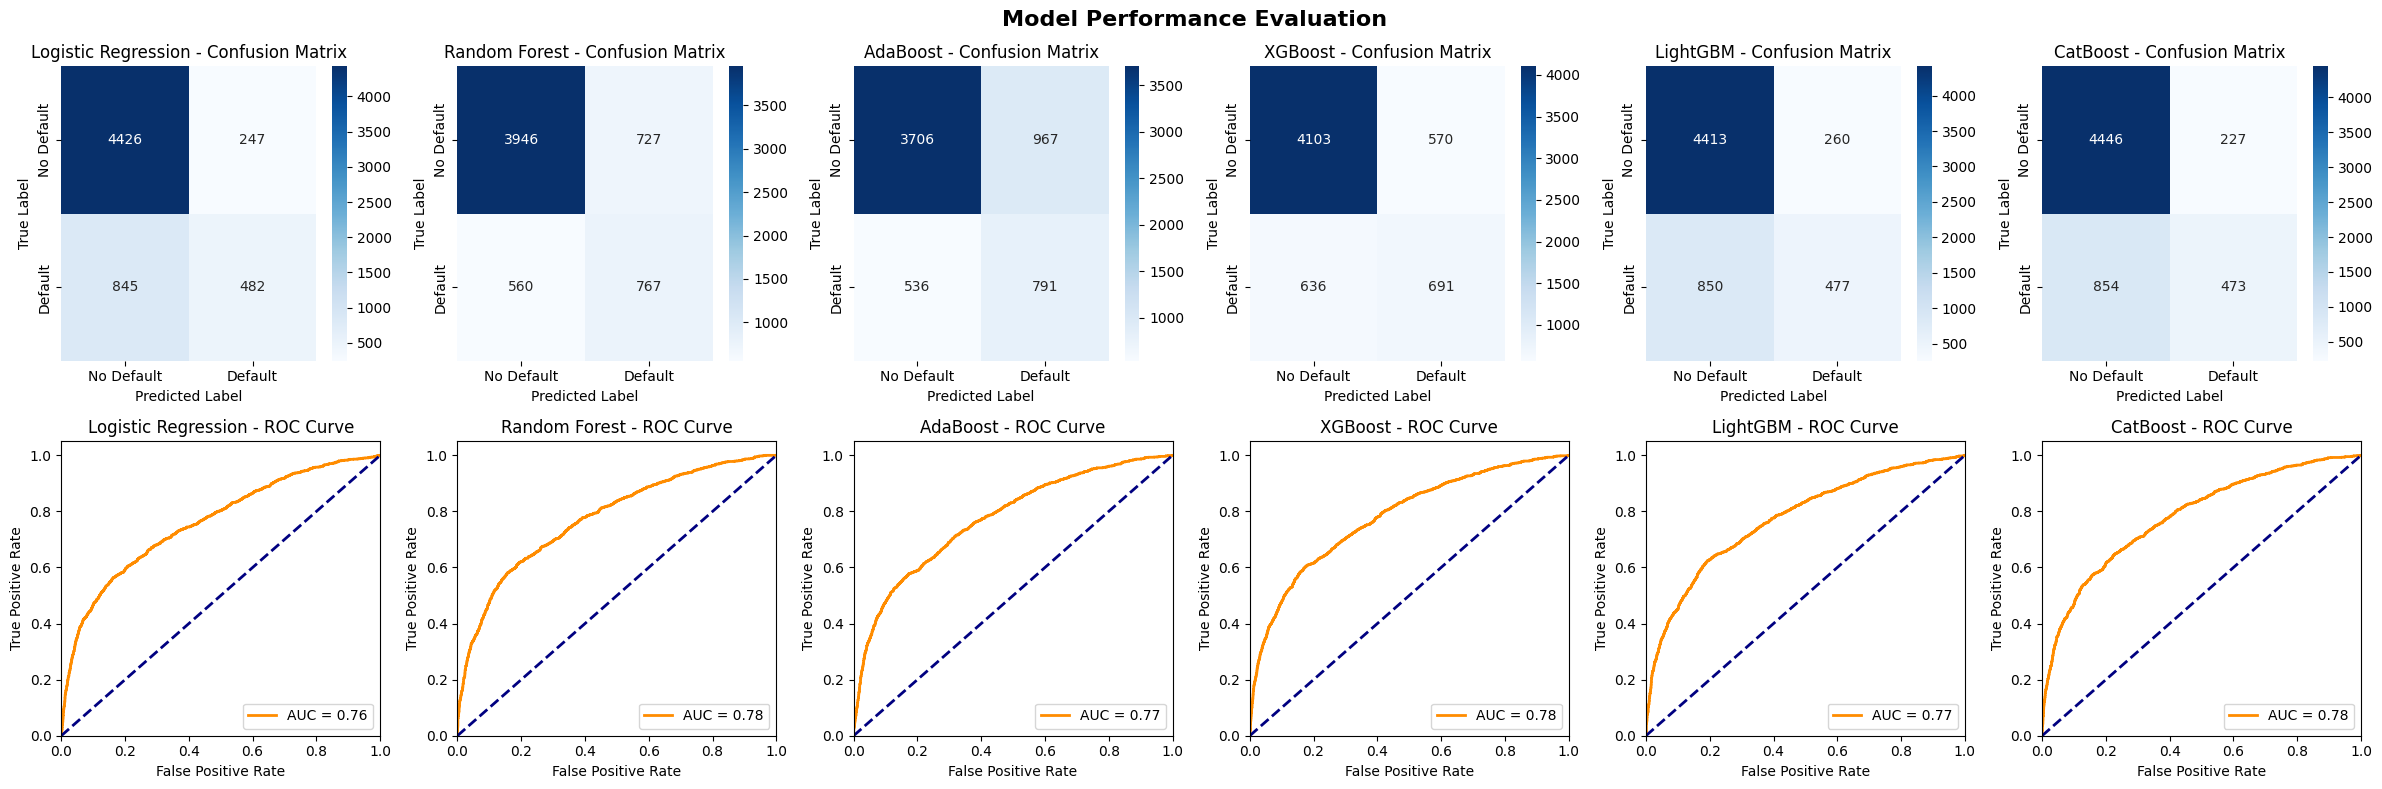


📋 Model Comparison Summary Table:
| Model               |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC | Training Time   |   TP |   TN |   FP |   FN |
|:--------------------|-----------:|------------:|---------:|-----------:|----------:|:----------------|-----:|-----:|-----:|-----:|
| Logistic Regression |     0.818  |      0.6612 |   0.3632 |     0.4689 |    0.761  | 2 min 43 sec    |  482 | 4426 |  247 |  845 |
| Random Forest       |     0.7855 |      0.5134 |   0.578  |     0.5438 |    0.7767 | 1 min 1 sec     |  767 | 3946 |  727 |  560 |
| AdaBoost            |     0.7495 |      0.4499 |   0.5961 |     0.5128 |    0.7728 | 1 min 52 sec    |  791 | 3706 |  967 |  536 |
| XGBoost             |     0.799  |      0.548  |   0.5207 |     0.534  |    0.7801 | 0 min 13 sec    |  691 | 4103 |  570 |  636 |
| LightGBM            |     0.815  |      0.6472 |   0.3595 |     0.4622 |    0.7739 | 0 min 29 sec    |  477 | 4413 |  260 |  850 |
| CatBoost            |     0.8198

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Results summary
fig, axes = plt.subplots(2, len(best_models), figsize=(4 * len(best_models), 8))
fig.suptitle("Model Performance Evaluation", fontsize=16, fontweight='bold')

metrics_summary = []
conf_matrix_data = []

for idx, (model_name, model_info) in enumerate(best_models.items()):
    model = model_info["best_estimator"]
    
    predictions = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, pred_proba)

    total_seconds = model_info["training_time_seconds"]
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    training_time = f"{minutes} min {seconds} sec"

    # Confusion matrix and its components
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()

    # Add to summary
    metrics_summary.append({
        "Model": model_name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "Training Time": training_time,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    })

    # Save confusion matrix for exporting if needed
    conf_matrix_data.append({
        "Model": model_name,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    })

    # Plot confusion matrix
    sns.heatmap(
        cm,
        annot=True, 
        fmt="d",
        cmap="Blues",
        xticklabels=["No Default", "Default"],
        yticklabels=["No Default", "Default"],
        ax=axes[0, idx]
    )
    axes[0, idx].set_title(f"{model_name} - Confusion Matrix")
    axes[0, idx].set_xlabel("Predicted Label")
    axes[0, idx].set_ylabel("True Label")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    axes[1, idx].plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
    axes[1, idx].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    axes[1, idx].set_xlim([0.0, 1.0])
    axes[1, idx].set_ylim([0.0, 1.05])
    axes[1, idx].set_xlabel("False Positive Rate")
    axes[1, idx].set_ylabel("True Positive Rate")
    axes[1, idx].set_title(f"{model_name} - ROC Curve")
    axes[1, idx].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Convert to DataFrame and display
df_metrics = pd.DataFrame(metrics_summary)
print("\n📋 Model Comparison Summary Table:")
print(df_metrics.to_markdown(index=False))

# Optionally export for Power BI
df_metrics.to_csv("model_metrics_summary.csv", index=False)


In [ ]:
'''
For a credit default prediction task — where catching defaulters is critical and class imbalance matters:
Best Overall Model: Random Forest
Best F1
Highest recall
Balanced performance without sacrificing too much accuracy
'''